# Load the packages

In [9]:
# Run in terminal or command prompt
# python3 -m spacy download en

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
import spacy
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

# Import News Text Data

In [2]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


In [3]:
df.head(15)

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc
10000,From: a207706@moe.dseg.ti.com (Robert Loper)\n...,7,rec.autos
10001,From: kimman@magnus.acs.ohio-state.edu (Kim Ri...,6,misc.forsale
10002,From: kwilson@casbah.acns.nwu.edu (Kirtley Wil...,2,comp.os.ms-windows.misc
10003,Subject: Re: Don't more innocents die without ...,0,alt.atheism
10004,From: livesey@solntze.wpd.sgi.com (Jon Livesey...,0,alt.atheism


# Remove emalis and newline characters

In [4]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<input>:5: DeprecationWarning: invalid escape sequence \S
<input>:8: DeprecationWarning: invalid escape sequence \s
<ipython-input-4-10af9153bd18>:5: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-4-10af9153bd18>:8: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


# Tokenize and Clean-up using gensim's simple_preprocess

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


# Lemmatization

In [18]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
# if you get error message, try again with administrator access
nlp = spacy.load('en',disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['where s  thing subject what car be nntp post host rac wam umd edu organization university maryland college park line be wonder anyone out there could enlighten car see other day be door sport car look be late early be call bricklin door be really small addition front bumper be separate rest body be know anyone can tellme model name engine spec year production where car be make history whatev info have funky look car mail thank bring  neighborhood lerxst', 'guy subject clock poll final call summary final call si clock report keyword acceleration clock upgrade article shelley qvfo innc organization university washington line nntp post host carson washington edu fair number brave soul who upgrade  si clock oscillator have share  experience poll send brief message detail  experience procedure top speed attain cpu rat speed add card adapter heat sink hour usage day floppy disk functionality floppy be especially request will be summarize next day so add network knowledge base have do clock

# Create the Document-Word matrix

In [20]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

# Check the Sparsicity

In [21]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.7758875693652992 %


# Build LDA model with sklearn

In [22]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

C:\Users\test\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


# Diagnose model performance with perplexity and log likelihood

In [23]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -9963843.29557063
Perplexity:  2059.040804623151
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 20,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


# GridSearch the best LDA model

In [24]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

C:\Users\test\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\test\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\test\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\test\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. Thi

C:\Users\test\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\test\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\test\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)
C:\Users\test\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. Thi

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [25]:
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

# See the best topic model and its parameters

In [34]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 15}
Best Log Likelihood Score:  -3423736.7182559115
Model Perplexity:  2004.5183124357766


In [36]:
best_lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.9, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=15, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

# Compare LDA Model Performance Scores

C:\Users\test\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\test\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
C:\Users\test\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


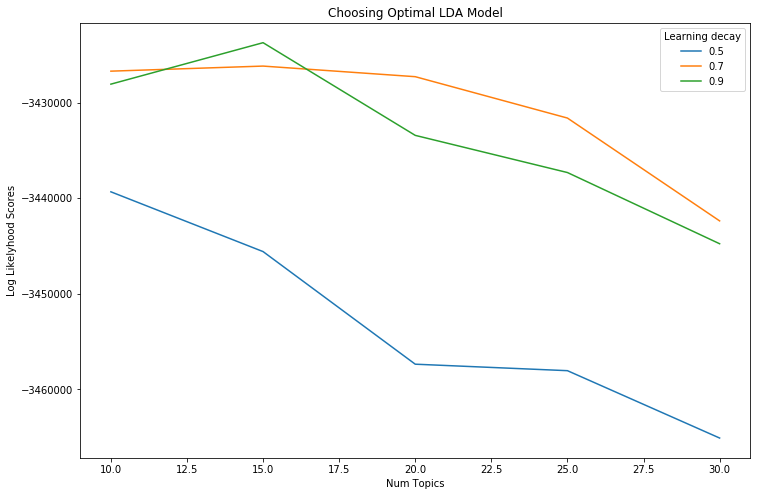

In [27]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

# See the dominant topic in each document

In [37]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,dominant_topic
Doc0,0.25,0,0,0,0,0,0.6,0,0,0,0,0,0,0,0.14,6
Doc1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.99,14
Doc2,0.06,0,0,0,0,0,0.27,0,0,0,0.44,0,0,0,0.21,10
Doc3,0,0,0,0,0,0,0,0.07,0,0,0,0,0.68,0,0.24,12
Doc4,0,0,0,0,0,0,0,0,0,0,0,0,0.97,0,0,12
Doc5,0.33,0,0,0,0,0,0.42,0,0,0,0.05,0,0,0,0.19,6
Doc6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.97,14
Doc7,0,0,0,0,0,0,0,0.27,0,0,0,0,0.26,0,0.46,14
Doc8,0,0,0,0,0,0.11,0.59,0,0,0,0,0.29,0,0,0,6
Doc9,0,0,0,0,0.72,0,0,0,0.27,0,0,0,0,0,0,4


# Review topics distribution across documents

In [38]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,14,2549
1,6,1958
2,12,1544
3,7,1192
4,1,1128
5,11,976
6,4,693
7,10,344
8,5,277
9,0,264


# Visualize the LDA model with pyLDAvis

In [39]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\test\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
6      100.873779   82.004379       1        1  13.648811
12    -201.656967   84.404289       2        1  12.349878
14      40.568485  221.733078       3        1  12.150508
11     201.967758  185.313644       4        1  12.017826
7      113.386795 -213.398697       5        1  10.542394
4      228.906433 -123.977310       6        1   9.585613
1     -254.011459  -63.989914       7        1   7.767730
5      -26.596954 -271.384399       8        1   6.188067
10    -104.359543  191.266785       9        1   5.736602
3     -108.692642  -35.026596      10        1   3.042625
0      -26.379841   62.006618      11        1   2.987485
9      243.913467   26.107241      12        1   1.255711
8       96.830070  -48.747116      13        1   1.110727
2       -9.384491 -119.812859      14        1   0.971715
13    -153.736679 -184.959137      15        1   0.644310, topic_info=     Category          Freq          Term         Total  loglift  logprob
term                                                                     
5343  Default   4120.000000           max   4120.000000  30.0000  30.0000
4766  Default   2302.000000           key   2302.000000  29.0000  29.0000
1266  Default   1837.000000           car   1837.000000  28.0000  28.0000
9569  Default   3047.000000        window   3047.000000  27.0000  27.0000
9218  Default   8898.000000           use   8898.000000  26.0000  26.0000
3276  Default   3067.000000          file   3067.000000  25.0000  25.0000
8135  Default   1970.000000         space   1970.000000  24.0000  24.0000
5048  Default  13091.000000          line  13091.000000  23.0000  23.0000
2678  Default   2513.000000         drive   2513.000000  22.0000  22.0000
3534  Default   1985.000000          game   1985.000000  21.0000  21.0000
8400  Default  12267.000000       subject  12267.000000  20.0000  20.0000
6166  Default  11345.000000  organization  11345.000000  19.0000  19.0000
3666  Default   2598.000000           god   2598.000000  18.0000  18.0000
1451  Default   1499.000000          chip   1499.000000  17.0000  17.0000
498   Default   7661.000000       article   7661.000000  16.0000  16.0000
9659  Default  10031.000000         write  10031.000000  15.0000  15.0000
8640  Default   1536.000000          team   1536.000000  14.0000  14.0000
9148  Default   5612.000000    university   5612.000000  13.0000  13.0000
6431  Default   5921.000000        people   5921.000000  12.0000  12.0000
475   Default   1317.000000      armenian   1317.000000  11.0000  11.0000
3790  Default   1678.000000           gun   1678.000000  10.0000  10.0000
5245  Default   1728.000000           man   1728.000000   9.0000   9.0000
5921  Default   4781.000000          nntp   4781.000000   8.0000   8.0000
4078  Default   4997.000000          host   4997.000000   7.0000   7.0000
7636  Default   6985.000000           say   6985.000000   6.0000   6.0000
2882  Default    903.000000    encryption    903.000000   5.0000   5.0000
3693  Default   1971.000000    government   1971.000000   4.0000   4.0000
6837  Default   2380.000000       program   2380.000000   3.0000   3.0000
9566  Default   1547.000000           win   1547.000000   2.0000   2.0000
2225  Default   2195.000000           day   2195.000000   1.0000   1.0000
...       ...           ...           ...           ...      ...      ...
5979  Topic15     32.313608          nswc     33.327409   5.0139  -5.5622
9241  Topic15     30.515348       utrecht     31.489550   5.0133  -5.6194
5045  Topic15     28.273814        linden     29.227777   5.0116  -5.6957
5632  Topic15     51.428493       moncton     53.361891   5.0078  -5.0974
1454  Topic15     33.808627           cho     35.083558   5.0077  -5.5169
1622  Topic15    117.348494           col    122.045319   5.0055  -4.2725
9418  Topic15     23.327235           vus     24.275037   5.0049  -5.8880
9055  Topic

# The topic's keywords

In [40]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaa,aaron,abandon,abbreviation,abc,abide,ability,able,abolish,abomination,...,zion,zionism,zionist,zip,zisfein,zone,zoology,zoom,zubov,zurich
Topic0,0.067507,0.068045,0.067631,0.068321,0.071271,1.092885,0.072339,5.196171,0.069582,0.067359,...,0.068309,0.068160,0.068633,0.067384,0.067345,0.089823,0.067393,0.067981,0.075535,0.067317
Topic1,60.180683,0.678921,0.067330,4.212207,87.011692,0.067350,42.404115,52.557903,0.067488,0.068638,...,0.067323,0.067437,0.067398,0.067601,0.069711,87.367064,0.068924,0.099826,9.671183,0.081281
Topic2,0.067442,0.067855,0.067318,0.234001,0.067426,0.067374,0.068580,0.068722,0.067490,0.067312,...,0.067382,0.068013,0.069754,0.067305,0.067363,0.067655,0.067442,0.067621,0.067464,0.067490
Topic3,0.067293,0.067390,0.067455,0.067327,0.068289,13.491485,37.177289,8.046858,0.067387,0.067223,...,0.071602,0.067343,0.067322,0.071391,30.558274,0.067688,0.067453,0.067950,0.067490,0.067266
Topic4,0.067818,6.243101,30.970726,0.071294,0.068536,21.509657,42.260720,71.386153,6.753598,13.020351,...,0.067935,0.068346,0.271984,14.144719,0.067440,0.113899,0.067182,0.067539,0.067307,0.067482


# Get the top 15 keywords each topic

In [41]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,car,subject,write,organization,line,article,fbi,engine,dog,nntp,host,batf,driver,distribution,mile
Topic 1,game,team,line,play,year,good,subject,organization,win,player,write,university,hockey,season,article
Topic 2,ground,radio,georgia,radar,detector,outlet,michael,doug,wiring,xterm,neutral,resurrection,day,university,sabbath
Topic 3,key,encryption,chip,use,clipper,security,privacy,escrow,information,public,algorithm,technology,secure,government,device
Topic 4,say,people,gun,god,think,believe,make,write,thing,use,mean,religion,christian,good,argument
Topic 5,armenian,say,people,turkish,come,kill,know,war,world,time,woman,greek,child,armenia,turk
Topic 6,write,line,article,good,subject,organization,just,think,know,make,time,look,say,people,use
Topic 7,write,subject,line,know,organization,say,god,post,christian,think,article,just,good,people,make
Topic 8,max,giz,pat,jon,objective,communication,qax,drive,online,netcom,access,guest,slave,line,morality
Topic 9,wire,circuit,homosexual,gay,man,amp,article,cramer,clayton,voltage,tube,power,sex,sexual,write


# Predict the topics for a new piece of text

In [42]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

# Predict the topic
mytext = ["Some text about christianity and bible"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)

['say', 'people', 'gun', 'god', 'think', 'believe', 'make', 'write', 'thing', 'use', 'mean', 'religion', 'christian', 'good', 'argument']


# Cluster documents that share simiar topics and plot

In [43]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Percentage of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))


Component's weights: 
 [[ 0.07  0.13  0.02  0.04  0.08  0.05  0.32  0.15  0.02  0.03  0.08  0.11
   0.38  0.01  0.83]
 [ 0.11  0.3   0.02  0.05  0.22  0.1   0.69  0.29  0.02  0.02  0.08  0.3
  -0.07  0.01 -0.42]]
Perc of Variance Explained: 
 [0.11 0.16]


Text(0.5,1,'Segregation of Topic Clusters')

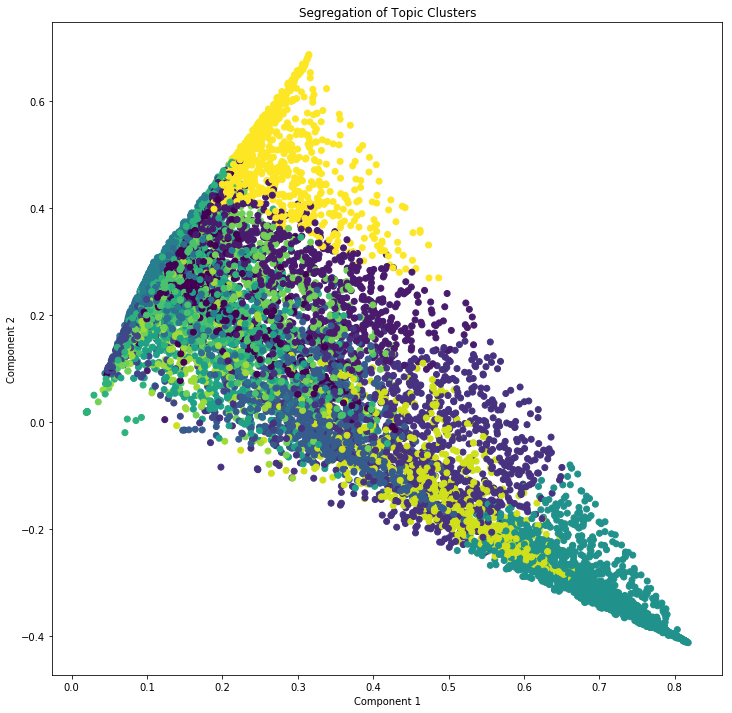

In [49]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title("Segregation of Topic Clusters", )

# Get similar documents for any given piece of text

In [47]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [54]:
# Get similar documents
mytext = ["Some text about christianity and bible"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:1000])

Topic KeyWords:  ['say', 'people', 'gun', 'god', 'think', 'believe', 'make', 'write', 'thing', 'use', 'mean', 'religion', 'christian', 'good', 'argument']
Topic Prob Scores of text:  [[0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
Most Similar Doc's Probs:   [[0.  0.  0.  0.  0.8 0.  0.  0.1 0.  0.  0.  0.  0.  0.  0. ]]

 From: mathew Subject: Alt.Atheism FAQ: Constructing a Logical Argument Summary: Includes a list of logical fallacies Keywords: FAQ, atheism, argument, fallacies, logic Expires: Thu, 20 May 1993 10:52:14 GMT Distribution: world Organization: Mantis Consultants, Cambridge. UK. Supersedes: Lines: 632 Archive-name: atheism/logic Alt-atheism-archive-name: logic Last-modified: 5 April 1993 Version: 1.4 Constructing a Logical Argument Although there is much argument on Usenet, the general quality of argument found is poor. This article attempts to provide a gentle introduction to logic, in the hope of improving the general level of debate. Logic is the scien